In [8]:
install.packages("reshape")

Installing package into 'C:/Users/Aigerim_acer/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'reshape' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Aigerim_acer\AppData\Local\Temp\RtmpKufLlr\downloaded_packages


In [9]:
library(lubridate)

In [10]:
library(dplyr)
library(forecast)
library(reshape)
library(ggplot2)
library(tidyverse)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'forecast' was built under R version 4.0.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'reshape' was built under R version 4.0.3"

Attaching package: 'reshape'


The following object is masked from 'package:dplyr':

    rename


The following object is masked from 'package:lubridate':

    stamp


Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.3     v purrr   0.3.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::as.difftime() masks base::as.difftim

In [11]:
#update.packages(ask = FALSE)

In [12]:
#install.packages("e1071")

In [13]:
#install.packages("gbm")

In [62]:
library(caret)
library(e1071)
library(gbm)
library(dismo)

Warning message:
"package 'dismo' was built under R version 4.0.3"
Loading required package: raster

Warning message:
"package 'raster' was built under R version 4.0.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.0.3"

Attaching package: 'raster'


The following object is masked from 'package:e1071':

    interpolate


The following object is masked from 'package:tidyr':

    extract


The following object is masked from 'package:dplyr':

    select




# Data Preparation

In [15]:
Sys.setlocale(locale="russian")
item_categories = read.csv("item_categories.csv",
                 encoding = "UTF-8")
items = read.csv("items.csv",
                 encoding = "UTF-8")
sales_train = read.csv("sales_train.csv",
                 encoding = "UTF-8")
shops = read.csv("shops.csv",
                 encoding = "UTF-8")
test = read.csv("test.csv",
                 encoding = "UTF-8")

[1] "LC_COLLATE=Russian_Russia.1251;LC_CTYPE=Russian_Russia.1251;LC_MONETARY=Russian_Russia.1251;LC_NUMERIC=C;LC_TIME=Russian_Russia.1251"

In [16]:
head(items)

,item_name,item_id,item_category_id
,<chr>,<int>,<int>
1,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
2,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
3,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
5,***КОРОБКА (СТЕКЛО) D,4,40
6,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) D,5,40


In [17]:
head(sales_train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,02.01.2013,0,59,22154,999.00,1
2,03.01.2013,0,25,2552,899.00,1
3,05.01.2013,0,25,2552,899.00,-1
4,06.01.2013,0,25,2554,1709.05,1
5,15.01.2013,0,25,2555,1099.00,1
6,10.01.2013,0,25,2564,349.00,1


In [18]:
head(test)

,ID,shop_id,item_id
,<int>,<int>,<int>
1,0,5,5037
2,1,5,5320
3,2,5,5233
4,3,5,5232
5,4,5,5268
6,5,5,5039


In [19]:
nrow(test)

[1] 214200

# Getting an insight into data to Choose Features

In [20]:
sales_train = merge(sales_train, items[,c("item_id", "item_category_id")], by = "item_id")

In [21]:
sales_train$date = as.Date(sales_train$date, "%d.%m.%Y")

In [22]:
sales_train$year = year(sales_train$date)
sales_train$year =  as.factor(sales_train$year)

sales_train$month = month(sales_train$date)
sales_train$month = as.factor(sales_train$month)

sales_train$day = day(sales_train$date)
sales_train$day = as.factor(sales_train$day)

sales_train$weekdays =  weekdays(sales_train$date)
sales_train$weekdays = as.factor(sales_train$weekdays)

In [24]:
head(sales_train) 
#понедельник-Monday; вторник-Tuesday; среда-Wednesday; четверг-Thursday; пятница-Friday; суббота-Saturday; воскресенье-Sunday

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,year,month,day,weekdays
,<int>,<date>,<int>,<int>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>
1,0,2014-09-01,20,54,58,1,40,2014,9,1,понедельник
2,1,2014-09-11,20,55,4490,1,76,2014,9,11,четверг
3,1,2014-10-20,21,55,4490,1,76,2014,10,20,понедельник
4,1,2014-04-04,15,55,4490,1,76,2014,4,4,пятница
5,1,2014-04-02,15,55,4490,1,76,2014,4,2,среда
6,1,2014-07-06,18,55,4490,1,76,2014,7,6,воскресенье


In [25]:
sales_train$item_category_id =  as.factor(sales_train$item_category_id)

In [26]:
sales_shop = sales_train %>%
    select(shop_id, item_cnt_day) %>%
    group_by(shop_id) %>%
    summarise(item_cnt_day =  sum(item_cnt_day, na.rm = T))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


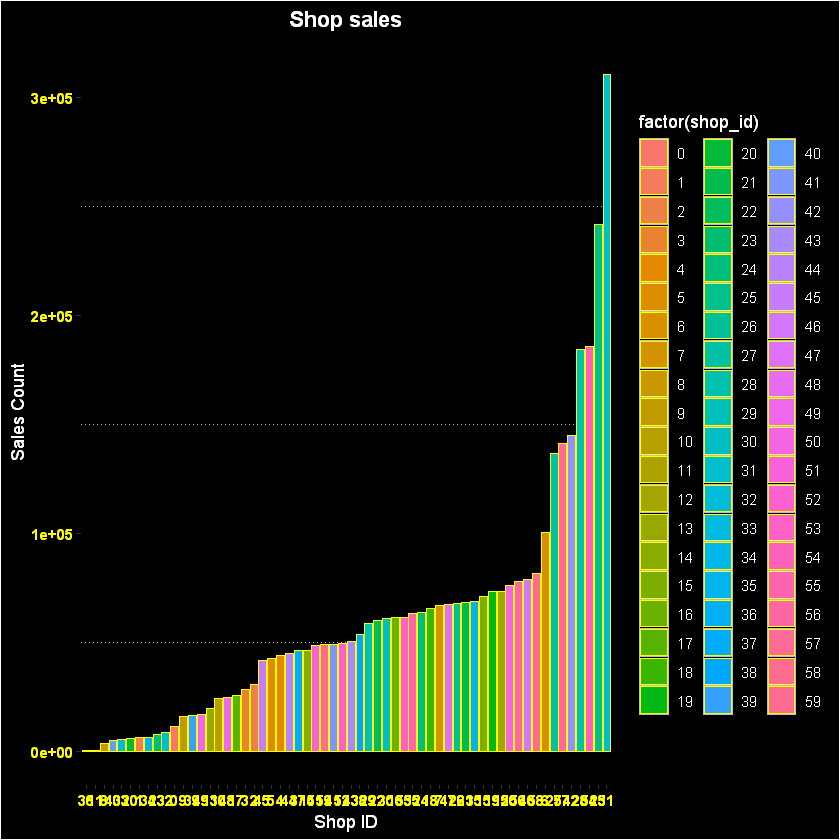

In [27]:
ggplot(data =  sales_shop, 
       mapping = aes(x = reorder(shop_id, item_cnt_day), 
                     y = item_cnt_day, 
                     fill = factor(shop_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    # coord_flip() +
    xlab("Shop ID") + ylab("Sales Count")+
    # geom_label(stat = "identity",position = position_dodge(width = 1),hjust = "center", aes(label = item_cnt_day)) +
    ggtitle(label = "Shop sales") +
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

In [28]:
# sales item category

sales_category = sales_train %>%
    select(item_category_id, item_cnt_day) %>%
    group_by(item_category_id) %>%
    summarise(item_cnt_day =  sum(item_cnt_day, na.rm = T))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


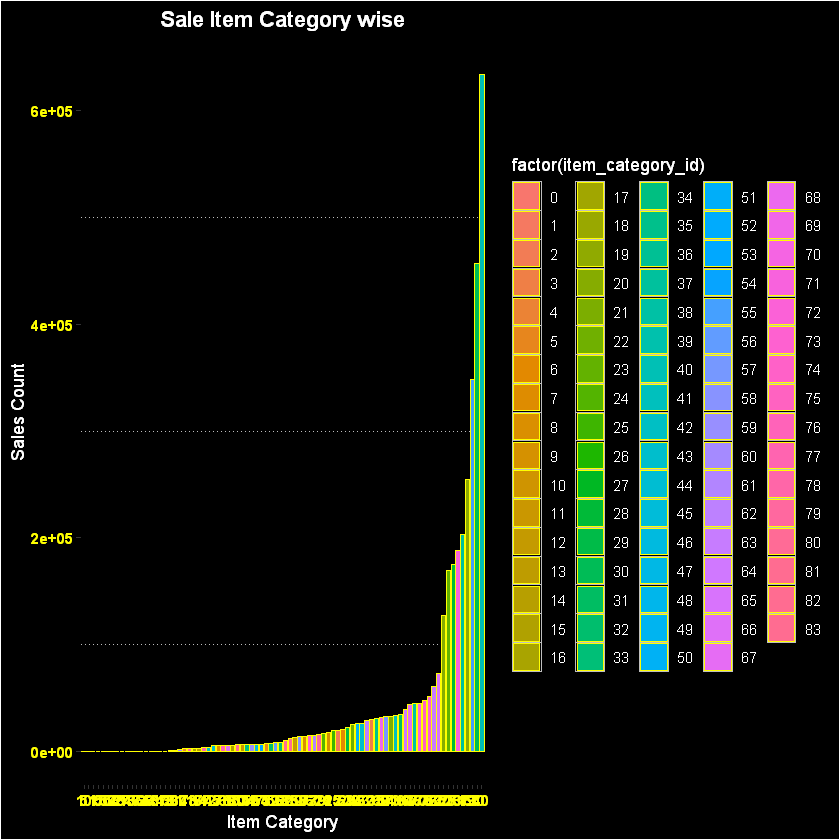

In [29]:
ggplot(data =  sales_category, 
       mapping = aes(x = reorder(item_category_id,item_cnt_day), 
                     y = item_cnt_day,
                     fill = factor(item_category_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    # coord_flip() +
    xlab("Item Category") + ylab("Sales Count") +
    ggtitle("Sale Item Category wise")+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

In [30]:
items_pop_shop = sales_train %>%
    select(shop_id, item_id) %>%
    group_by(shop_id) %>%
    summarise(item_id = n_distinct(item_id))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


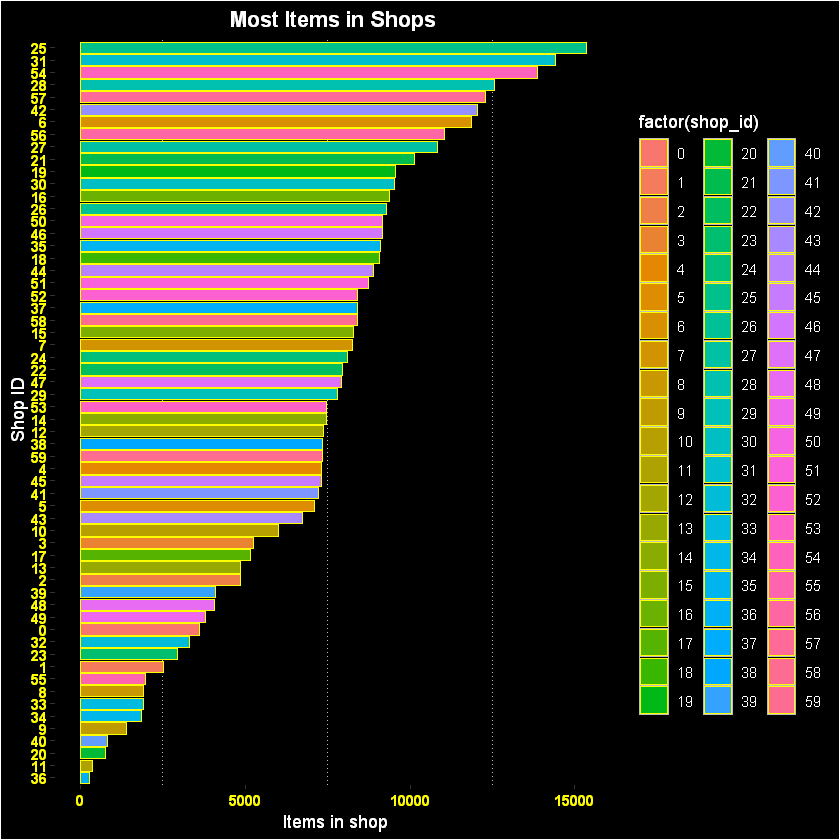

In [31]:
ggplot(data = items_pop_shop,
       mapping = aes(x = reorder(shop_id,item_id),
                     y = item_id,
                     fill = factor(shop_id)))+
    geom_histogram(stat = "identity", color = "yellow") +
    xlab(" Shop ID")+ ylab(" Items in shop")+
    ggtitle("Most Items in Shops") +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [32]:
#category of items most available

category_item_most = sales_train %>%
    select(item_category_id, item_id) %>%
    group_by(item_category_id) %>%
    summarise(item_id =  n_distinct(item_id))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


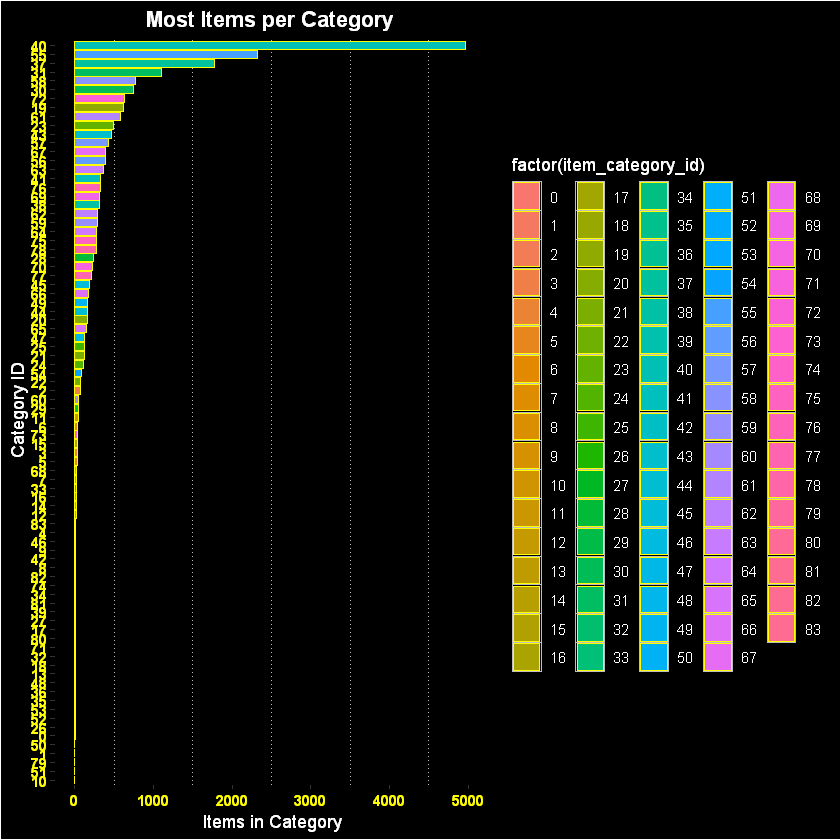

In [33]:
ggplot(data = category_item_most,
       mapping = aes(x = reorder(item_category_id,item_id),
                     y = item_id,
                     fill = factor(item_category_id)))+
    geom_histogram(stat = "identity", color = "yellow") +
    xlab(" Category ID")+ ylab(" Items in Category")+
    ggtitle("Most Items per Category") +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [34]:
## most sold and popular item in a shop
 # filter(sold_item_count == max(sold_item_count)) %>%

sold_popular_items  =  sales_train %>%
    group_by(shop_id, item_id) %>%
    summarise(sold_item_count = sum(item_cnt_day)) %>%
    arrange(desc(sold_item_count))


`summarise()` regrouping output by 'shop_id' (override with `.groups` argument)



In [35]:
most_popular_items  =  sales_train %>%
    group_by(shop_id, item_id) %>%
    summarise(sold_item_count = sum(item_cnt_day)) %>%
    filter(sold_item_count == max(sold_item_count)) %>%
    arrange(desc(sold_item_count))

`summarise()` regrouping output by 'shop_id' (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


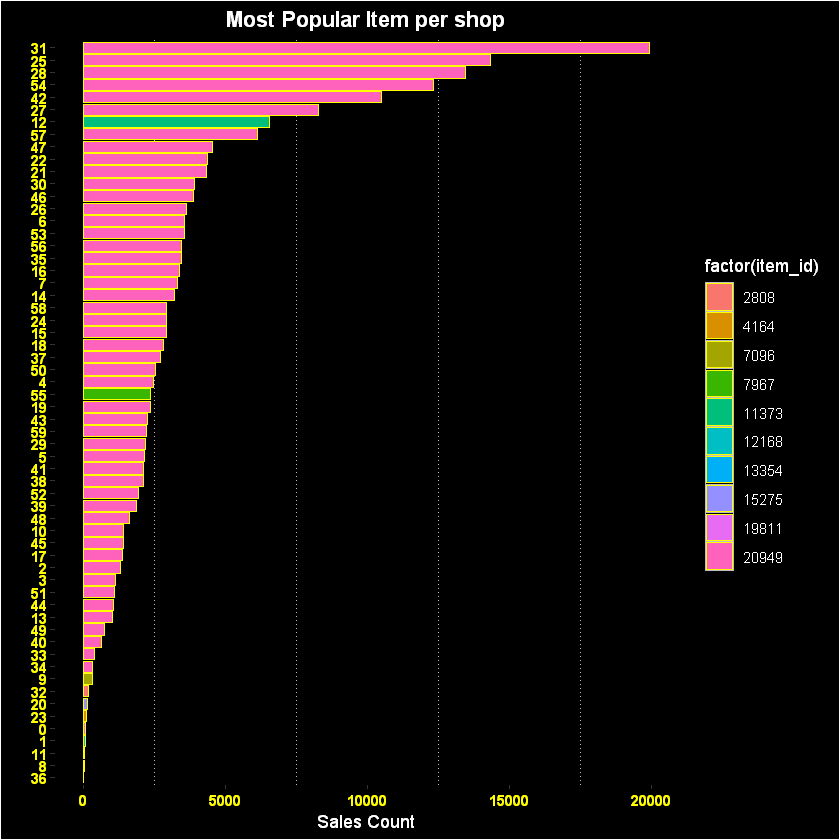

In [36]:
ggplot(data = most_popular_items,
       mapping = aes(x = reorder(shop_id, sold_item_count),
                     y = sold_item_count,
                     fill = factor(item_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    xlab("") + ylab("Sales Count") +
    ggtitle("Most Popular Item per shop") +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [37]:
# shop has most category of items 
most_category_shop = sales_train %>%
    select(shop_id, item_category_id) %>%
    group_by(shop_id) %>%
    summarise(category_count =  n_distinct(item_category_id)) %>%
    arrange(desc(category_count))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


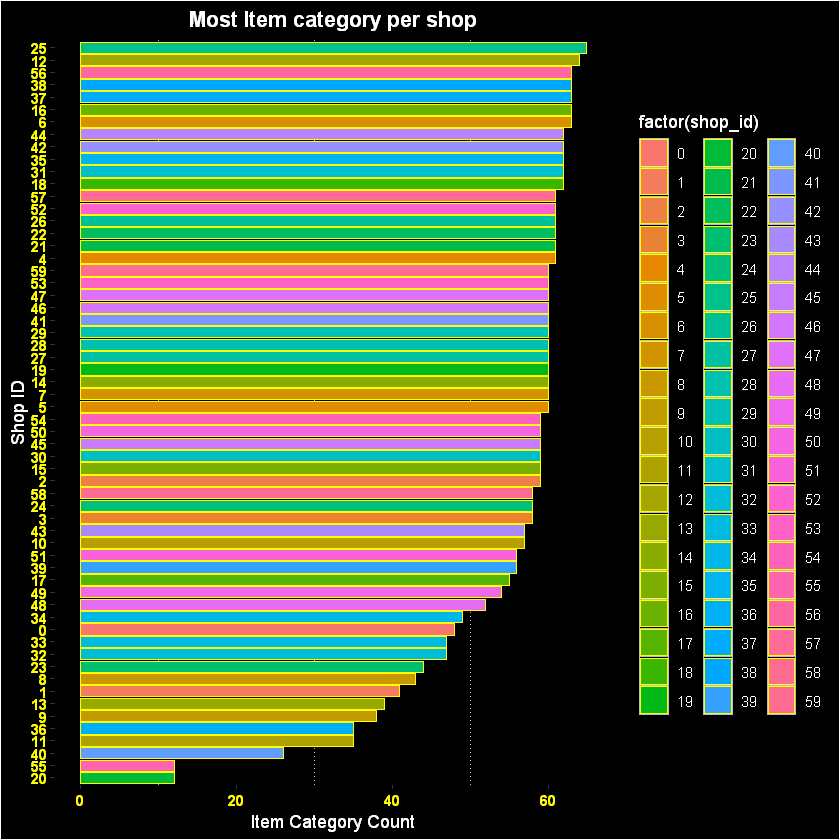

In [38]:
ggplot(data = most_category_shop,
       mapping = aes(x = reorder(shop_id, category_count),
                     y = category_count,
                     fill = factor(shop_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    xlab("Shop ID") + ylab("Item Category Count") +
    ggtitle("Most Item category per shop") +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [39]:
# item category most popular and most sold in each shop

pop_sold_category =  sales_train %>%
    group_by(shop_id, item_category_id) %>%
    summarise(category_count = sum(item_cnt_day)) %>%
    filter(category_count == max(category_count)) %>%
    arrange(desc(category_count))


`summarise()` regrouping output by 'shop_id' (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


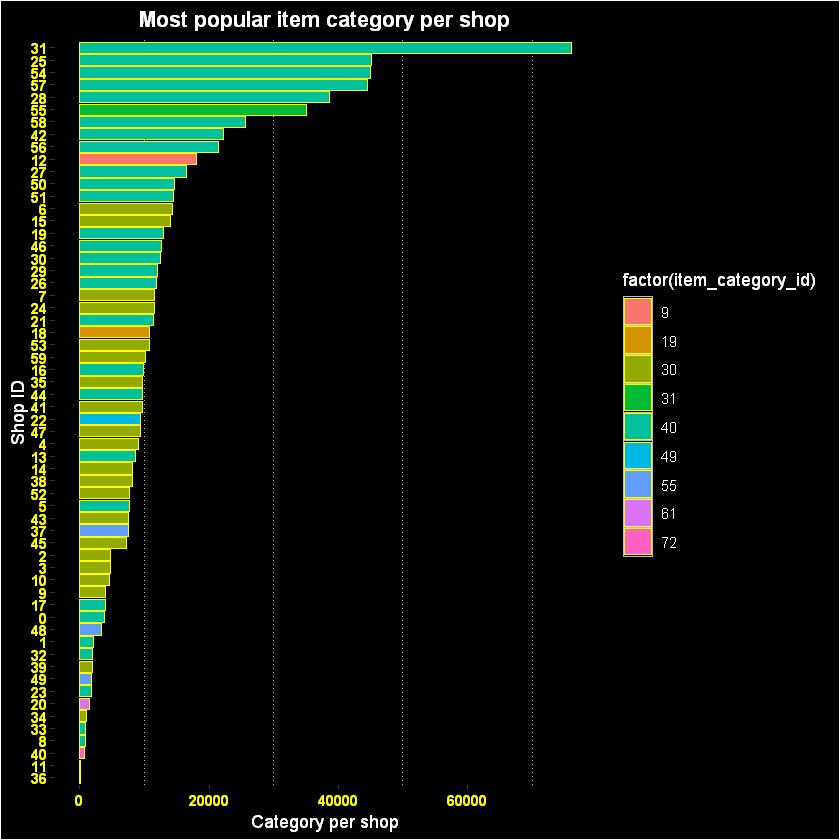

In [40]:
ggplot(data =  pop_sold_category, 
       mapping = aes(x = reorder(shop_id, category_count),
                     y =  category_count,
                     fill = factor(item_category_id))) +
    geom_histogram(stat ="identity", color = "yellow") +
    xlab("Shop ID")+ ylab("Category per shop") + 
    ggtitle("Most popular item category per shop")+
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [41]:
# which item category provides the greatest revenue in all shops

high_revenue_category = sales_train %>%
    group_by(item_category_id) %>%
    summarise(total_revenue = sum(item_cnt_day * item_price)) %>%
    arrange(desc(total_revenue))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


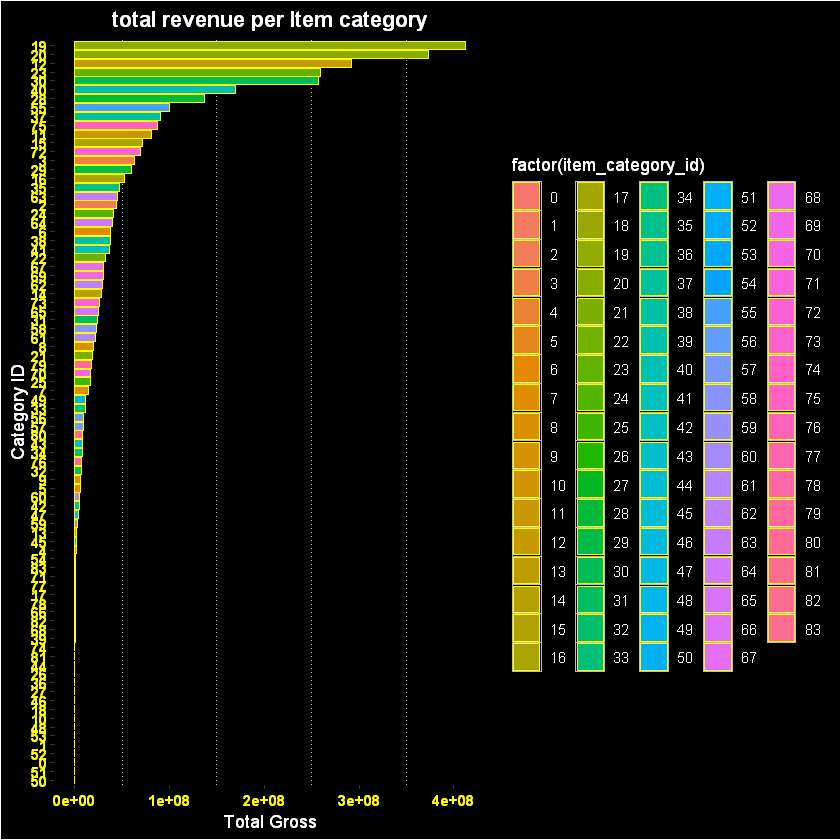

In [42]:
ggplot(high_revenue_category, 
       aes(x = reorder(item_category_id, total_revenue),
           y = total_revenue,
           fill = factor(item_category_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    xlab("Category ID") + ylab("Total Gross")+
    ggtitle("total revenue per Item category") +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [43]:
# categories available in each shop

item_category_per_shop = sales_train %>%
    group_by(shop_id) %>%
    summarise(item_category =  paste(sort(unique(item_category_id)), collapse = ", ")) 



`summarise()` ungrouping output (override with `.groups` argument)



In [44]:
head(item_category_per_shop)

shop_id,item_category
<int>,<chr>
0,"0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 19, 21, 22, 23, 25, 28, 29, 30, 33, 35, 37, 38, 40, 41, 43, 45, 49, 55, 56, 57, 59, 60, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 81, 82, 83"
1,"2, 3, 4, 5, 6, 11, 13, 14, 15, 19, 21, 22, 23, 25, 28, 29, 30, 33, 35, 37, 38, 40, 41, 49, 55, 56, 58, 62, 63, 64, 65, 67, 69, 70, 72, 73, 75, 77, 81, 82, 83"
2,"2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 47, 49, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 79, 81, 82, 83"
3,"2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 35, 37, 38, 40, 41, 42, 43, 45, 47, 49, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 79, 80, 83"
4,"2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 35, 37, 38, 40, 41, 42, 43, 45, 47, 49, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 79, 80, 81, 82, 83"
5,"2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 49, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 79, 80, 83"


In [45]:
most_sold_item_per_category = sales_train %>%
    group_by(item_category_id, item_id) %>%
    summarise(total_sales = sum(item_price * item_cnt_day)) %>%
    filter(total_sales == max(total_sales)) %>%
    arrange(desc(total_sales))

`summarise()` regrouping output by 'item_category_id' (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


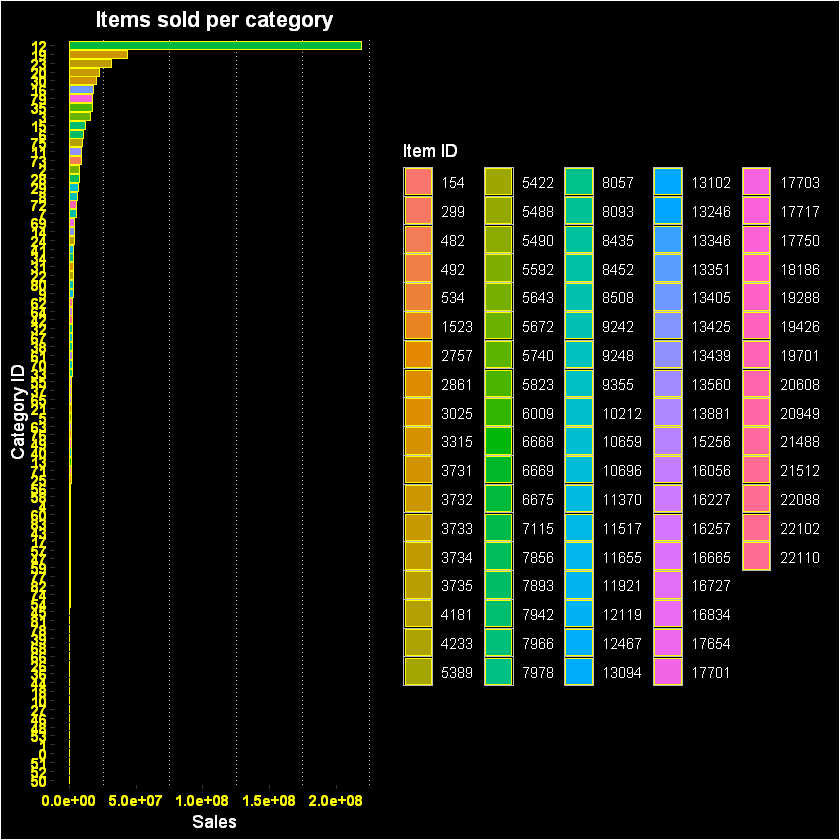

In [46]:
ggplot(most_sold_item_per_category,
       aes(x = reorder(item_category_id, total_sales), 
           y = total_sales,
           fill = factor(item_id))) +
    geom_histogram(stat = "identity", color = "yellow") +
    labs(title = "Items sold per category",x = "Category ID", y = "Sales", fill = "Item ID") +
    coord_flip()+ 
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

`summarise()` regrouping output by 'month' (override with `.groups` argument)



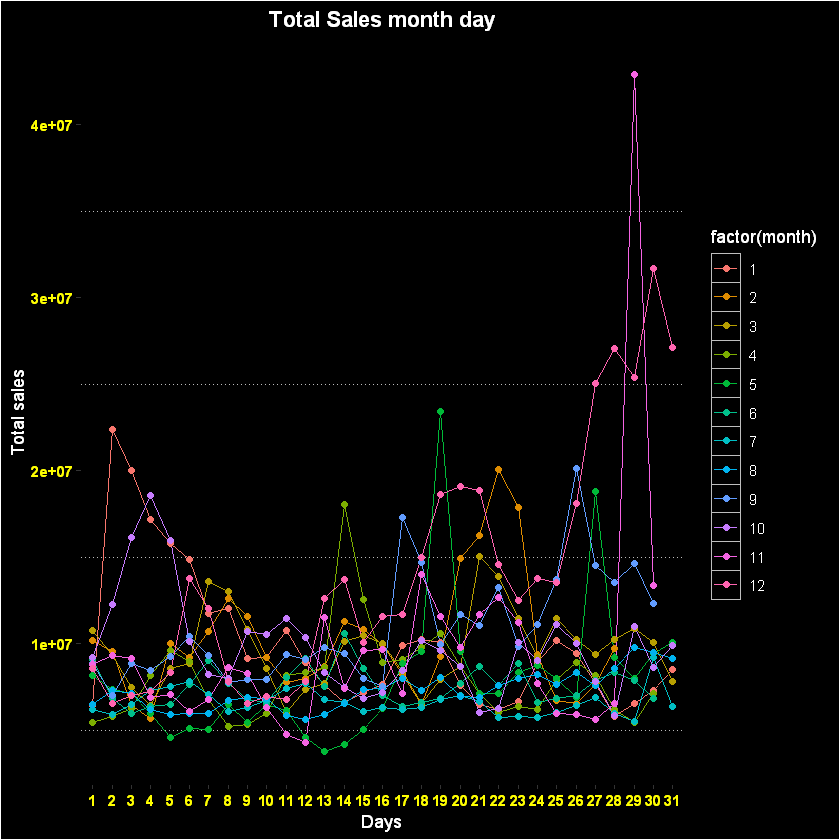

In [47]:
# day and month total sales 
day_month_total_sales =  sales_train %>%
    group_by(month, day) %>%
    summarise(total_sales =  sum(item_price * item_cnt_day))

ggplot(day_month_total_sales, 
       aes(x = day, 
           y = total_sales, 
           group =  month, 
           color =  factor(month))) +
    geom_line() + 
    geom_point() +
    labs(title = "Total Sales month day", x = "Days", y = "Total sales", fill = "Months") +
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


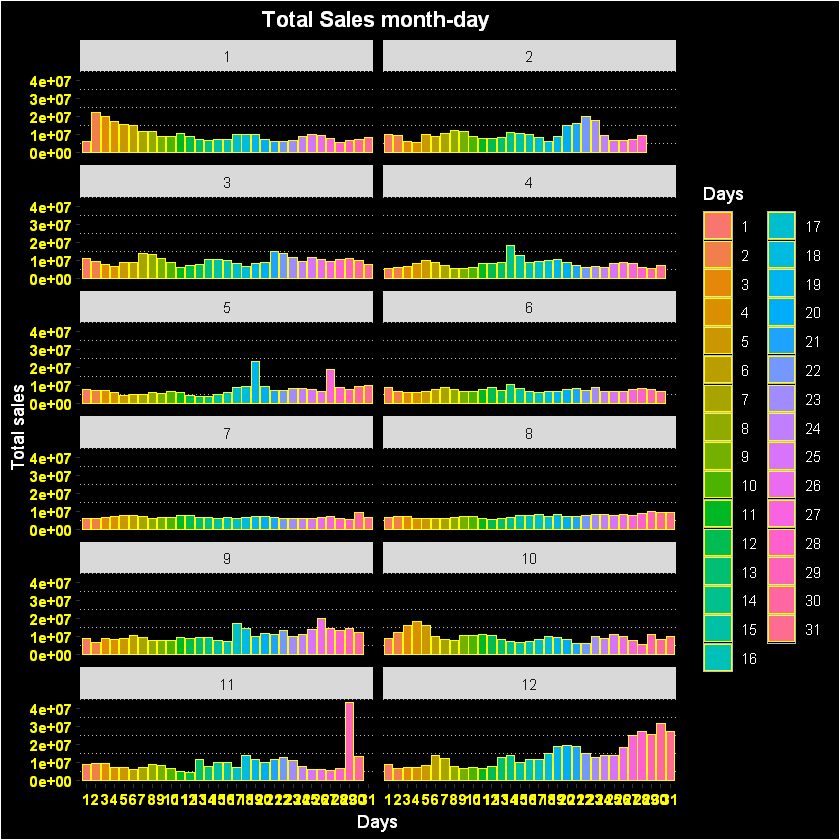

In [37]:
ggplot(day_month_total_sales, 
       aes(x = day, 
           y = total_sales, 
           fill =  factor(day))) +
    geom_histogram(stat = "identity", color = "yellow") +
    labs(title = "Total Sales month-day ", x = "Days", y = "Total sales", fill = "Days") +
    facet_wrap(~month, ncol = 2)+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 


In [48]:
# year total sales
yearly_sales = sales_train %>%
    group_by(year) %>%
    summarise(yearly_sale = sum(item_price * item_cnt_day))

`summarise()` ungrouping output (override with `.groups` argument)



Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


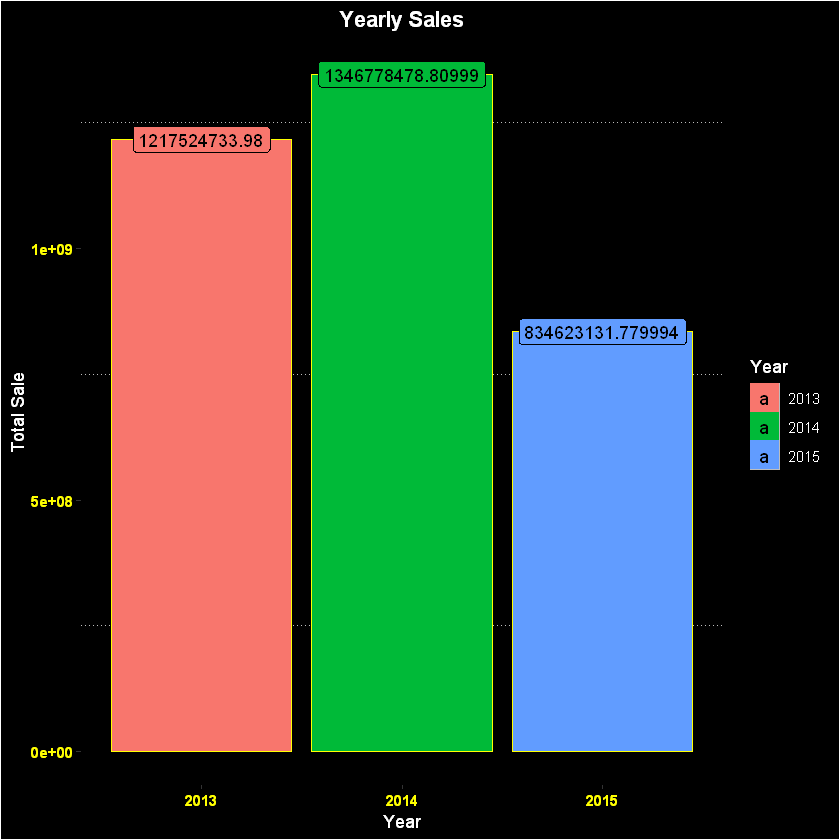

In [49]:
ggplot(yearly_sales, aes(x =  year, y = yearly_sale, fill =  factor(year)))+
    geom_histogram(stat = "identity", color = "yellow")+
    labs(title = "Yearly Sales", x = "Year", y = "Total Sale", fill = "Year")+
    geom_label(stat = "identity",position = position_dodge(width = 1),hjust = "center", aes(label = yearly_sale)) +
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [50]:
year_month_sales = sales_train %>%
    group_by(year, month) %>%
    summarise(year_month_sale = sum(item_price*item_cnt_day)) %>%
    arrange(year)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



In [51]:
year_month_sales$year_month_sale = round(year_month_sales$year_month_sale, 2)

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


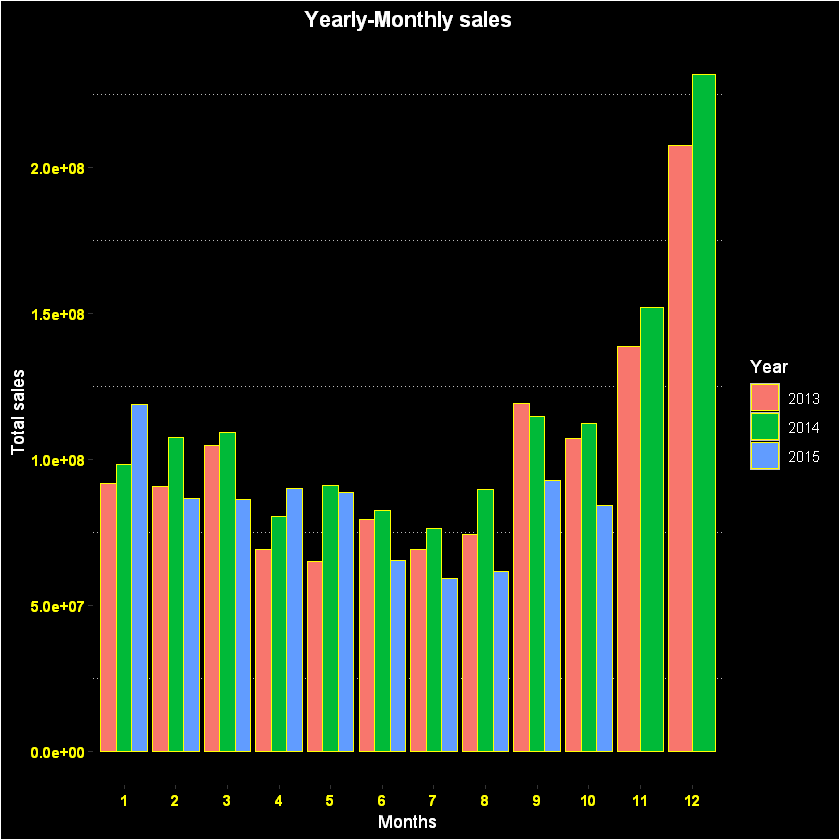

In [52]:
ggplot(year_month_sales, aes(x =  month, y = year_month_sale, fill =  factor(year)))+
    geom_histogram(stat = "identity", position = "dodge", color = "yellow") +
    labs(title = "Yearly-Monthly sales", x = "Months", y =  "Total sales", fill = "Year")+
    # geom_label(stat = "identity",position = position_dodge(width = 1),hjust = "center", aes(label = ym_sale)) +
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    ) 

In [53]:
# number of items sold each day

daily_sale = sales_train %>%
    group_by(date) %>%
    summarise(items_sold =  sum(item_cnt_day))

`summarise()` ungrouping output (override with `.groups` argument)



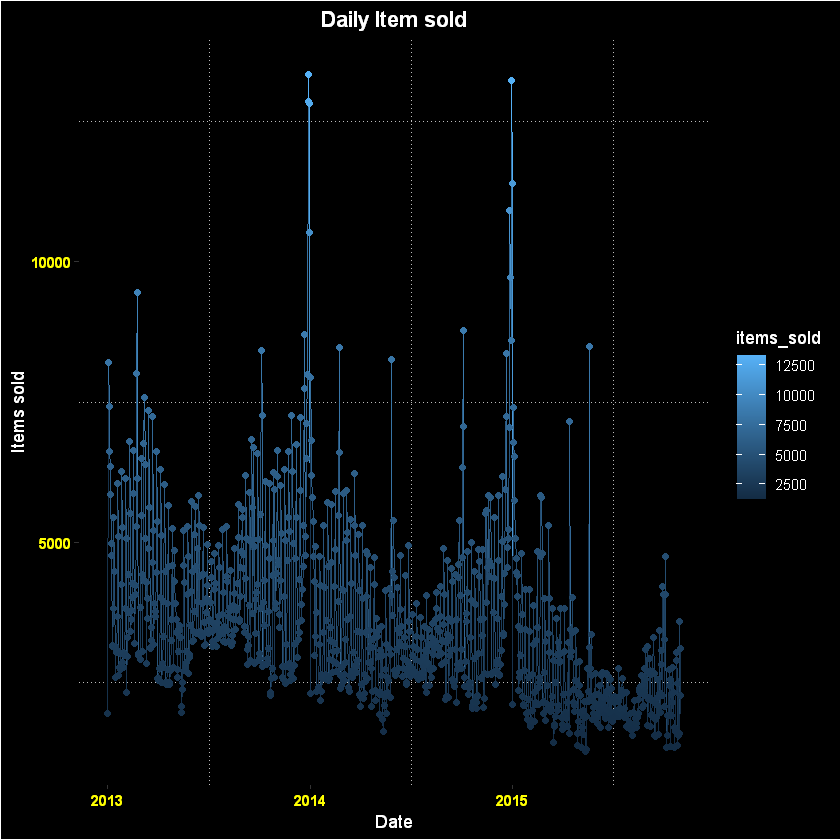

In [54]:
ggplot(daily_sale, aes(x =  date, y = items_sold, color =  items_sold)) +
    geom_line() +
    geom_point()+
    labs(title = "Daily Item sold", x =  "Date", y = "Items sold")+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

`summarise()` ungrouping output (override with `.groups` argument)



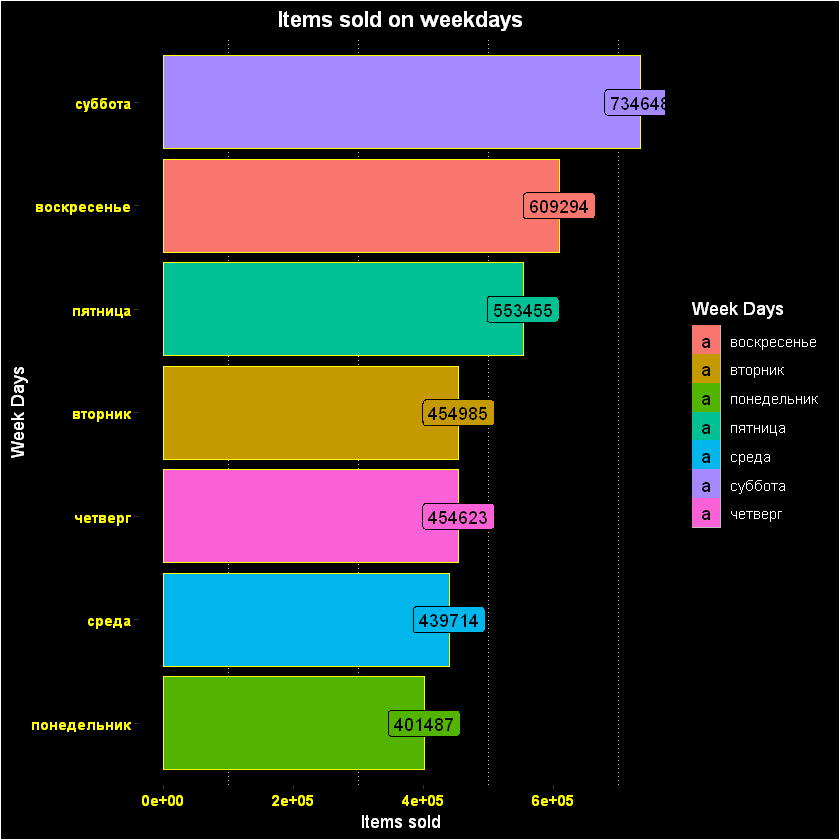

In [55]:
# items sold on weekdays

weekdays_item_sold = sales_train %>%
    group_by(weekdays) %>%
    summarise(item_sold = sum(item_cnt_day)) %>%
    arrange(desc(item_sold))

ggplot(weekdays_item_sold, aes(x =reorder(weekdays, item_sold), y =  item_sold, fill = factor(weekdays)))+
    geom_bar(stat = "identity", color = "yellow") +
    labs(title = "Items sold on weekdays", x = "Week Days", y =  "Items sold", fill = "Week Days") +
    geom_label(stat = "identity",position = position_dodge(width = 1),hjust = "center", aes(label = item_sold)) +
    coord_flip()+
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

`summarise()` ungrouping output (override with `.groups` argument)



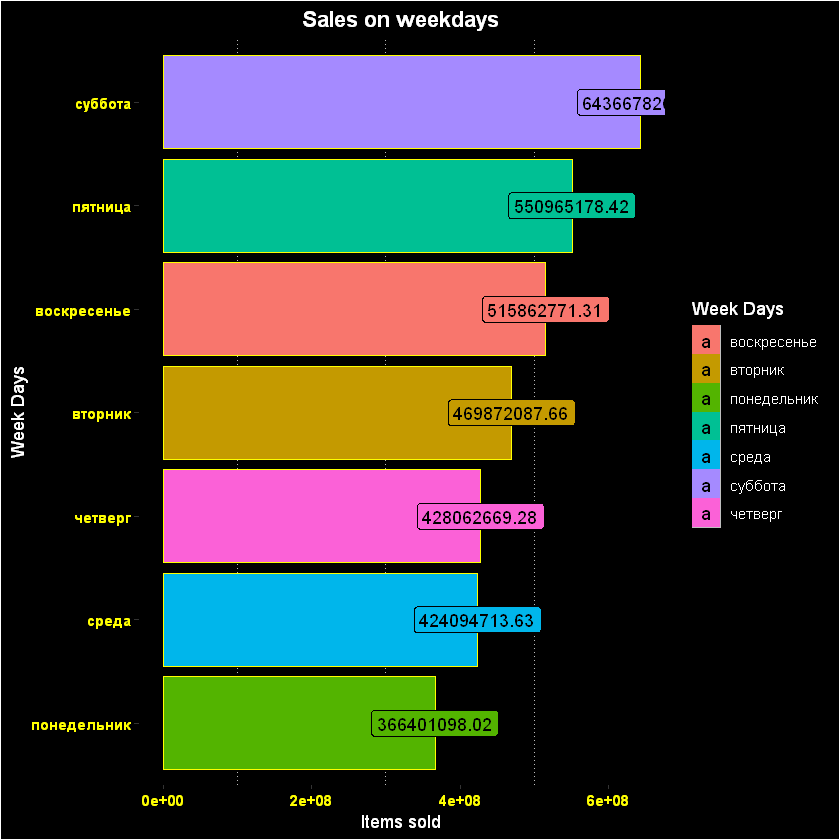

In [56]:
# sale profit on weekdays
weekdays_sales = sales_train %>%
    group_by(weekdays) %>%
    summarise(total_sale = sum(item_cnt_day * item_price)) %>%
    arrange(desc(total_sale))
weekdays_sales$total_sale = round(weekdays_sales$total_sale, 2)

ggplot(weekdays_sales, aes(x =reorder(weekdays, total_sale), y =  total_sale, fill = factor(weekdays)))+
    geom_bar(stat = "identity", color ="yellow") +
    labs(title = "Sales on weekdays", x = "Week Days", y =  "Items sold", fill = "Week Days") +
    coord_flip()+
    geom_label(stat = "identity",position = position_dodge(width = 1),hjust = "center", aes(label = total_sale)) +
    theme(
        # get rid of panel grids
        panel.grid.major = element_blank(),
        panel.grid.minor = element_line(colour = "gray",linetype = "dotted"),
        # Change plot and panel background
        plot.background=element_rect(fill = "black"),
        panel.background = element_rect(fill = 'black'),
        # Change legend 
        # legend.position = c(0.6, 0.07),
        # legend.direction = "horizontal",
        legend.background = element_rect(fill = "black", color = NA),
        legend.key = element_rect(color = "gray", fill = "black"),
        legend.title = element_text(color = "white"),
        legend.text = element_text(color = "white"),
        # align title to top center, top ledt is by default.
        plot.title = element_text(color = "white", hjust = 0.5, face = "bold"),
        # axis ticks to bold black
        axis.text=element_text(colour = "yellow",face = "bold"),
        axis.title.x = element_text(color = "white"),
        axis.title.y = element_text(color = "white")
    )

# Model Choice: GBM
##### Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

# Training

In [102]:
# GBM Model

gbm_model  =  gbm(item_cnt_day ~ shop_id + item_id,
                  data = sales_train,
                  shrinkage = 0.01,
                  distribution = "gaussian",
                  n.trees = 1000,
                  interaction.depth = 5, 
                  bag.fraction = 0.5,
                  train.fraction = 0.8,
                  # cv.folds = 5,
                  n.cores = -1,
                  verbose = T)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        6.0237         10.1986     0.0100    0.0009
     2        6.0227         10.1987     0.0100    0.0010
     3        6.0218         10.1988     0.0100    0.0010
     4        6.0206         10.1989     0.0100    0.0009
     5        6.0195         10.1990     0.0100    0.0008
     6        6.0185         10.1991     0.0100    0.0009
     7        6.0175         10.1992     0.0100    0.0009
     8        6.0166         10.1993     0.0100    0.0008
     9        6.0159         10.1994     0.0100    0.0007
    10        6.0152         10.1995     0.0100    0.0007
    20        6.0049         10.2012     0.0100    0.0007
    40        5.9870         10.2045     0.0100    0.0004
    60        5.9715         10.2079     0.0100    0.0006
    80        5.9612         10.2104     0.0100    0.0006
   100        5.9541         10.2132     0.0100    0.0002
   120        5.9433         10.2137     0.0100    0.0005
   140        

## Dividing total_train to sub_train and sub_test data

In [80]:
sales_shop_train = left_join(sales_train, shops, by = c('shop_id'))
total_train = left_join(sales_shop_train, items, by = c('item_id'))
#total_train = left_join(total_train, item_categories, by = c('item_category_id'))
total_train$date =  as.Date(total_train$date, format = "%d.%m.%Y")

#divide total train to train and test data
total_train$date =  as_datetime(total_train$date)
total_train = total_train %>% mutate(year = round_date(total_train$date, unit = "year"))
total_train = total_train %>% mutate(month = round_date(total_train$date, unit = "month"))
total_train = total_train %>% mutate(day = round_date(total_train$date, unit = "day"))

set.seed(2020, sample.kind = "Rounding")

test_partition <- createDataPartition(y = total_train$item_cnt_day, times = 1, p = 0.1, list= FALSE)
sub_train <- total_train[-test_partition, ]
sub_test <- total_train[test_partition, ]
test1=total_train$item_cnt_day[test_partition]

Warning message in set.seed(2020, sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"


In [69]:
nrow(sub_train)
nrow(sub_test)

[1] 2642263

[1] 293586

In [72]:
#dont include shops, items and prices in test set that do not appear in train set

sub_test = sub_test %>%
  semi_join(sub_train, by = 'shop_id') %>%
  semi_join(sub_train, by = 'item_id')%>%
  semi_join(sub_train, by = 'item_price')
head(sub_test)

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id.x,year,month,day,weekdays,shop_name,item_name,item_category_id.y
,<int>,<dttm>,<int>,<int>,<dbl>,<dbl>,<fct>,<dttm>,<dttm>,<dttm>,<fct>,<chr>,<chr>,<int>
1,27,2013-11-30,10,21,1198.0,1,19,2014-01-01,2013-12-01,2013-11-30,суббота,"Москва МТРЦ ""Афи Молл""","007 Legends [PS3, русская версия]",19
2,27,2013-10-14,9,7,838.6,1,19,2014-01-01,2013-10-01,2013-10-14,понедельник,"Воронеж ТРЦ ""Максимир""","007 Legends [PS3, русская версия]",19
3,27,2013-10-16,9,27,838.0,1,19,2014-01-01,2013-10-01,2013-10-16,среда,"Москва ТЦ ""МЕГА Белая Дача II""","007 Legends [PS3, русская версия]",19
4,27,2014-03-18,14,26,998.0,1,19,2014-01-01,2014-04-01,2014-03-18,вторник,"Москва ТЦ ""Ареал"" (Беляево)","007 Legends [PS3, русская версия]",19
5,28,2013-09-18,8,54,249.0,1,30,2014-01-01,2013-10-01,2013-09-18,среда,"Химки ТЦ ""Мега""","007 Legends [PС, Jewel, русская версия]",30
6,28,2013-04-16,3,12,398.0,1,30,2013-01-01,2013-05-01,2013-04-16,вторник,Интернет-магазин ЧС,"007 Legends [PС, Jewel, русская версия]",30


# Evaluation

### Using MAE to measure the average magnitude of the errors in a set of predictions

In [99]:
gbm_model_2  =  gbm(item_cnt_day ~ shop_id + item_id,
                  data = sub_train,
                  shrinkage = 0.01,
                  distribution = "gaussian",
                  n.trees = 1000,
                  interaction.depth = 5, 
                  bag.fraction = 0.5,
                  train.fraction = 0.8,
                  # cv.folds = 5,
                  n.cores = -1,
                  verbose = T)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        6.2748         10.2062     0.0100    0.0008
     2        6.2740         10.2063     0.0100    0.0008
     3        6.2732         10.2065     0.0100    0.0008
     4        6.2723         10.2066     0.0100    0.0008
     5        6.2715         10.2067     0.0100    0.0008
     6        6.2704         10.2068     0.0100    0.0007
     7        6.2695         10.2069     0.0100    0.0008
     8        6.2686         10.2070     0.0100    0.0007
     9        6.2676         10.2071     0.0100    0.0006
    10        6.2668         10.2072     0.0100    0.0008
    20        6.2586         10.2085     0.0100    0.0013
    40        6.2416         10.2117     0.0100    0.0012
    60        6.2243         10.2154     0.0100    0.0003
    80        6.2124         10.2174     0.0100    0.0006
   100        6.2014         10.2200     0.0100    0.0003
   120        6.1918         10.2203     0.0100    0.0001
   140        

In [101]:
result_2 = predict(gbm_model_2,newdata = test[,c("shop_id","item_id")], n.trees = 1000)
print(paste("gbm", mae(test1, result_2)))

Warning message in actual - predicted:
"длина большего объекта не является произведением длины меньшего объекта"


[1] "gbm 0.382608890672892"


# Changing the values of the parameters shrinkage = 0.1, n.trees = 100

In [95]:
gbm_model_1  =  gbm(item_cnt_day ~ shop_id + item_id,
                  data = sub_train,
                  shrinkage = 0.1,
                  distribution = "gaussian",
                  n.trees = 100,
                  interaction.depth = 5, 
                  bag.fraction = 0.5,
                  train.fraction = 0.8,
                  # cv.folds = 5,
                  n.cores = -1,
                  verbose = T)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        6.2664         10.2072     0.1000    0.0076
     2        6.2589         10.2084     0.1000    0.0071
     3        6.2535         10.2094     0.1000    0.0055
     4        6.2384         10.2120     0.1000    0.0124
     5        6.2343         10.2129     0.1000    0.0046
     6        6.2215         10.2152     0.1000    0.0068
     7        6.2137         10.2173     0.1000    0.0065
     8        6.2062         10.2193     0.1000    0.0032
     9        6.2026         10.2198     0.1000    0.0042
    10        6.2007         10.2217     0.1000    0.0014
    20        6.1601         10.2220     0.1000    0.0012
    40        6.1115         10.2294     0.1000    0.0007
    60        6.0905         10.2345     0.1000    0.0007
    80        6.0684         10.2358     0.1000    0.0000
   100        6.0485         10.2336     0.1000   -0.0014



In [98]:
result1 = predict(gbm_model_1,newdata = sub_test[,c("shop_id","item_id")], n.trees = 100)
print(paste("gbm", mae(test1, result1)))

[1] "gbm 0.382333033904658"


##  gbm (shrinkage = 0.1, n.trees = 100,) has the better result with the MAE of 0.382333033904658

# Result

In [103]:
# this model takes a long time to finish

# GBM Model

gbm_model  =  gbm(item_cnt_day ~ shop_id + item_id,
                  data = sales_train,
                  shrinkage = 0.1,
                  distribution = "gaussian",
                  n.trees = 100,
                  interaction.depth = 5, 
                  bag.fraction = 0.5,
                  train.fraction = 0.8,
                  # cv.folds = 5,
                  n.cores = -1,
                  verbose = T)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        6.0174         10.1995     0.1000    0.0083
     2        6.0111         10.2005     0.1000    0.0066
     3        6.0048         10.2015     0.1000    0.0072
     4        5.9940         10.2040     0.1000    0.0115
     5        5.9910         10.2061     0.1000    0.0031
     6        5.9834         10.2084     0.1000    0.0088
     7        5.9812         10.2103     0.1000    0.0024
     8        5.9771         10.2110     0.1000    0.0043
     9        5.9614         10.2113     0.1000    0.0082
    10        5.9525         10.2132     0.1000    0.0067
    20        5.9087         10.2128     0.1000    0.0007
    40        5.8641         10.2193     0.1000    0.0004
    60        5.8352         10.2243     0.1000    0.0007
    80        5.8160         10.2254     0.1000    0.0003
   100        5.7992         10.2251     0.1000    0.0004



In [104]:
result2 = predict(gbm_model,newdata = test[,c("shop_id","item_id")], n.trees = 100)

In [105]:
sub2 = data.frame(ID = test$ID, 
                  item_cnt_month =  result2)

In [106]:
sub2

ID,item_cnt_month
<int>,<dbl>
0,1.091349
1,1.091349
2,1.091349
3,1.091349
4,1.091349
5,1.091349
6,1.091349
7,1.091349
8,1.091349
